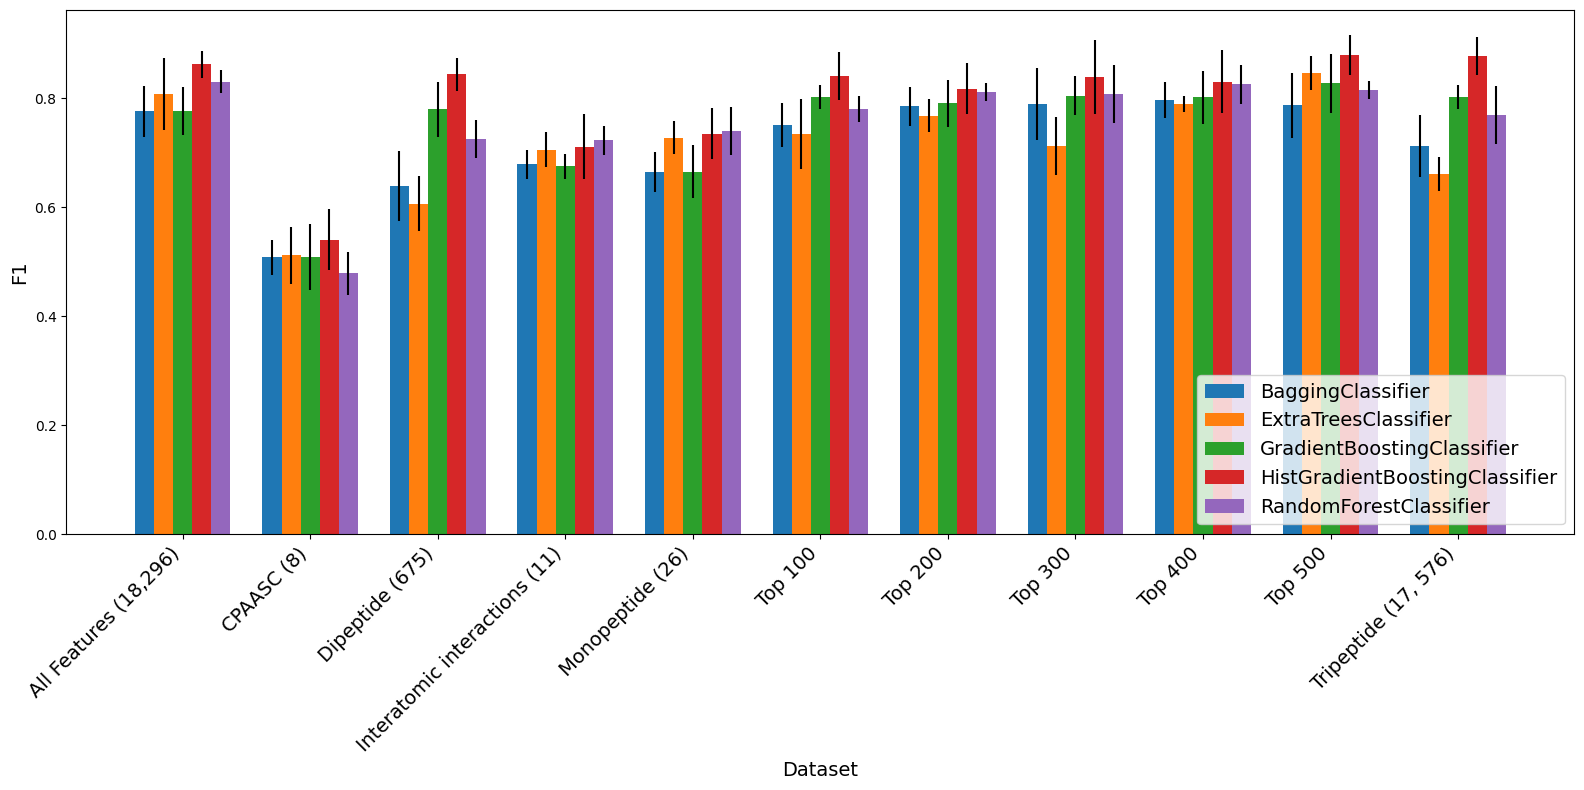

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
# Dados fornecidos
# Carregando os dados do arquivo CSV
df = pd.read_csv('analysis.csv',sep=',')

# Criando um DataFrame
df = pd.DataFrame(df)

# Agrupando os dados por algoritmo e dataset, e calculando a média e o desvio padrão
grouped = df.groupby(['Algorithm', 'Dataset']).agg(['mean', 'std'])

# Selecionando a métrica 'F1 macro' para o gráfico
metric = 'F1'
grouped_metric = grouped[metric]

# Preparando os dados para o gráfico
algorithms = df['Algorithm'].unique()
datasets = df['Dataset'].unique()

x = np.arange(len(datasets))  # Posições no eixo x
width = 00.15  # Largura das barras

fig, ax = plt.subplots(figsize=(16, 8))

# Plotando as barras para cada algoritmo
for i, algorithm in enumerate(algorithms):
    means = grouped_metric.loc[algorithm]['mean']
    stds = grouped_metric.loc[algorithm]['std']
    ax.bar(x + i * width, means, width, label=algorithm, yerr=stds)

# Adicionando labels, título e legendas
ax.set_xlabel('Dataset',fontsize=14)
ax.set_ylabel(metric, fontsize=14)
ax.set_title(f'',fontsize=14)
ax.set_xticks(x + width * (len(algorithms) - 1) / 2)
ax.set_xticklabels(datasets, rotation=45, ha='right',fontsize=14)
ax.legend(loc ='lower right',fontsize=14)

plt.tight_layout()
#plt.show()
plt.savefig('1_Algorithm_feature.pdf')

/tmp/ipykernel_106398/2475390317.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets, rotation=60, ha='right',fontsize=14)


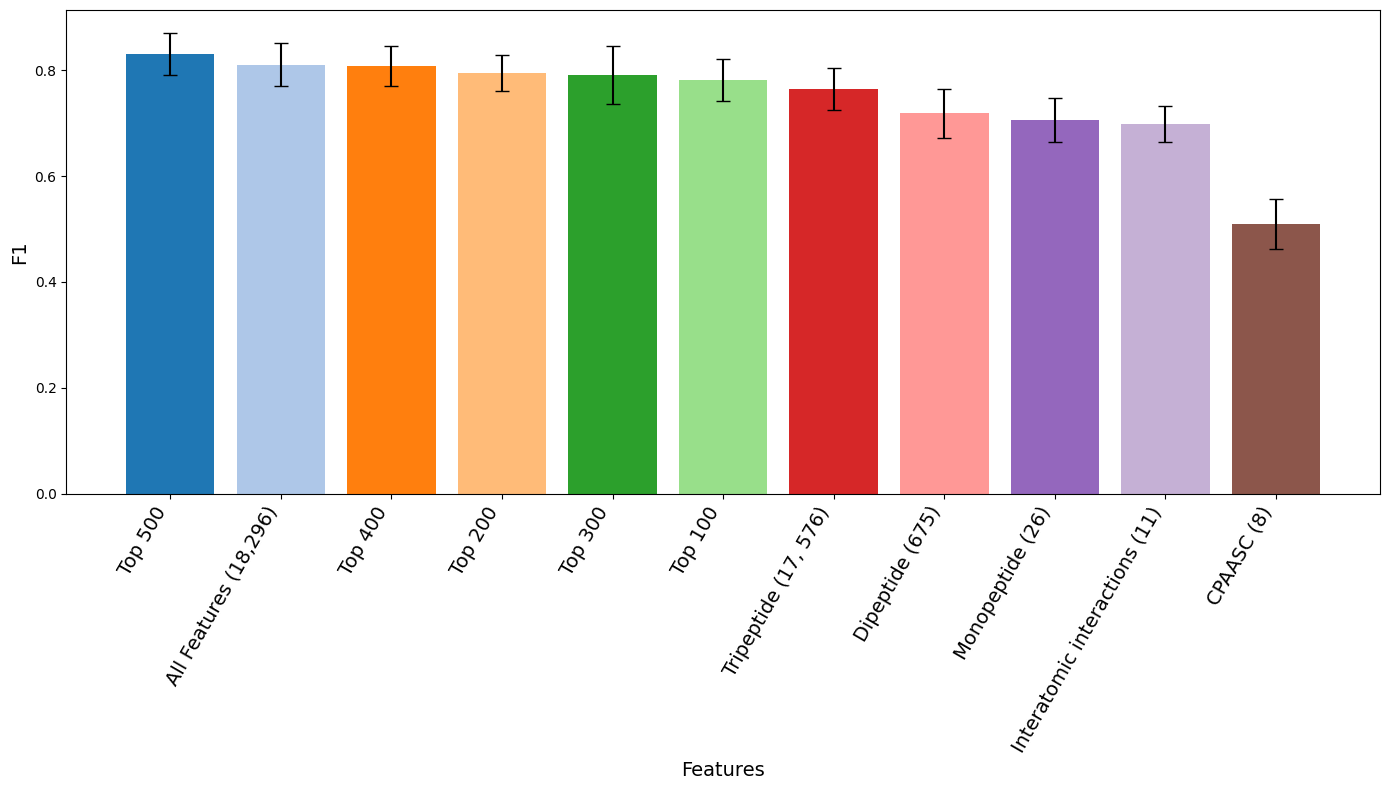

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Carregando os dados do arquivo CSV
df = pd.read_csv('analysis.csv', sep=',')

# Verifica se as colunas necessárias estão presentes
required_columns = ['Algorithm', 'Dataset', 'F1']
if not all(col in df.columns for col in required_columns):
    print("Erro: O arquivo CSV não contém todas as colunas necessárias.")
    print("Colunas necessárias:", required_columns)
    print("Colunas encontradas:", df.columns.tolist())
    exit()

# Agrupando os dados por dataset e calculando a média das médias e o desvio padrão consolidado
grouped = df.groupby(['Algorithm', 'Dataset'])['F1'].agg(['mean', 'std']).reset_index()
dataset_summary = grouped.groupby('Dataset').agg({'mean': 'mean', 'std': 'mean'}).reset_index()

# Ordenando os datasets pelo valor médio decrescente
dataset_summary = dataset_summary.sort_values(by='mean', ascending=False)

# Realizando ANOVA para verificar diferenças significativas entre datasets
anova_pvalue = stats.f_oneway(*[df[df['Dataset'] == dataset]['F1'] for dataset in df['Dataset'].unique()]).pvalue

# Teste post-hoc de Tukey
tukey = pairwise_tukeyhsd(df['F1'], df['Dataset'], alpha=0.05)
# Convertendo os resultados do teste de Tukey em um DataFrame
tukey_df = pd.DataFrame(tukey.summary().data[1:], columns=tukey.summary().data[0])

# Salvando como um arquivo CSV (separado por tabulação)
#tukey_df.to_csv('tukey_results.tsv', sep='\t', index=False)

# Obtendo pares significativos
significant_pairs = []
for res in tukey.summary().data[1:]:  # Pulando o cabeçalho
    group1, group2, pval = res[0], res[1], res[4]
    if pval < 0.05 and pval > 0:
        significant_pairs.append((group1, group2, pval))

# Preparando os dados para o gráfico
datasets = dataset_summary['Dataset']
means = dataset_summary['mean']
stds = dataset_summary['std']

# Definindo uma paleta de cores
colors = plt.cm.tab20.colors[:len(datasets)]

# Criando o gráfico
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(datasets, means, yerr=stds, color=colors, capsize=5)

# Adicionando labels e título
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('F1', fontsize=14)
ax.set_title('')
ax.set_xticklabels(datasets, rotation=45, ha='right',fontsize=14)

plt.tight_layout()

plt.savefig('1_F1_by_Feature.pdf')
plt.show()


/tmp/ipykernel_106398/1977045307.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets, rotation=45, ha='right')


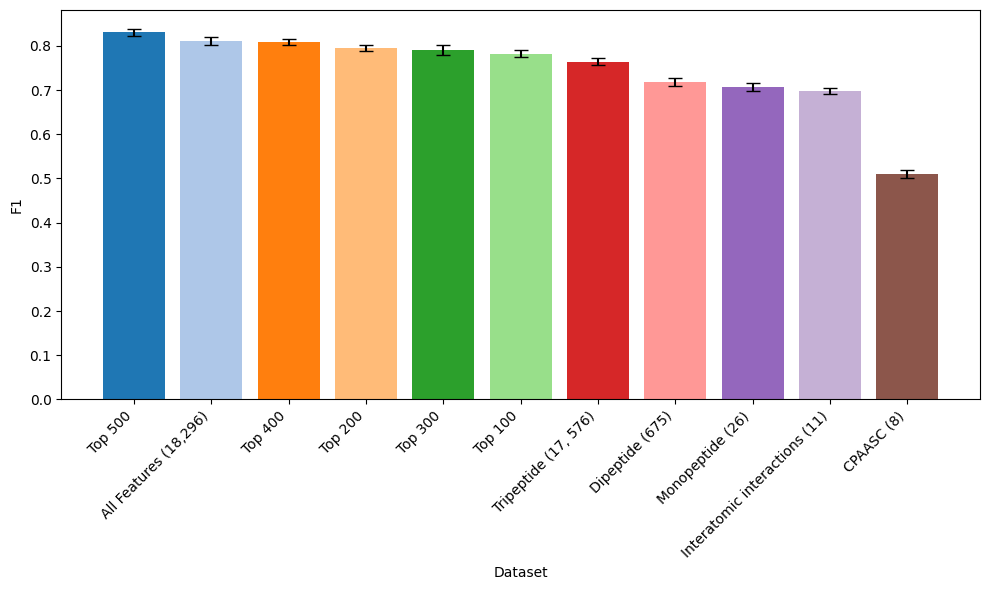

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Carregando os dados do arquivo CSV
df = pd.read_csv('analysis.csv', sep=',')

# Verifica se as colunas necessárias estão presentes
required_columns = ['Algorithm', 'Dataset', 'F1']
if not all(col in df.columns for col in required_columns):
    print("Erro: O arquivo CSV não contém todas as colunas necessárias.")
    print("Colunas necessárias:", required_columns)
    print("Colunas encontradas:", df.columns.tolist())
    exit()

# Agrupando os dados por dataset e calculando a média das médias e o erro padrão consolidado
grouped = df.groupby(['Algorithm', 'Dataset'])['F1'].agg(['mean', 'std', 'count']).reset_index()
dataset_summary = grouped.groupby('Dataset').agg({'mean': 'mean', 'std': 'mean', 'count': 'sum'}).reset_index()
dataset_summary['stderr'] = dataset_summary['std'] / np.sqrt(dataset_summary['count'])

# Ordenando os datasets pelo valor médio decrescente
dataset_summary = dataset_summary.sort_values(by='mean', ascending=False)

# Realizando ANOVA para verificar diferenças significativas entre datasets
anova_pvalue = stats.f_oneway(*[df[df['Dataset'] == dataset]['F1'] for dataset in df['Dataset'].unique()]).pvalue

# Teste post-hoc de Tukey
tukey = pairwise_tukeyhsd(df['F1'], df['Dataset'], alpha=0.05)

# Obtendo pares significativos
significant_pairs = []
for res in tukey.summary().data[1:]:  # Pulando o cabeçalho
    group1, group2, pval = res[0], res[1], res[4]
    if pval < 0.05:
        significant_pairs.append((group1, group2, pval))

# Preparando os dados para o gráfico
datasets = dataset_summary['Dataset']
means = dataset_summary['mean']
stderrs = dataset_summary['stderr']
stds = dataset_summary['std']

# Definindo uma paleta de cores
colors = plt.cm.tab20.colors[:len(datasets)]

# Criando o gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(datasets, means, yerr=stderrs, color=colors, capsize=5)

# Adicionando labels e título
ax.set_xlabel('Dataset')
ax.set_ylabel('F1')
ax.set_title('')
ax.set_xticklabels(datasets, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('1_F1_by_dataset_stderr.pdf')
plt.show()
